In [57]:
import pandas as pd
import numpy as np
import psycopg2
from analysys_funcs import *
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [60]:
# database connection

conn = psycopg2.connect(host='ep-black-pond-a2ydwdvs.eu-central-1.aws.neon.tech', database='Akademdb', user='Elizar54', password='XUpC1QOnGvA4')
cur = conn.cursor()

In [61]:
# getting data

df = pd.read_sql_query('select * from flats_new', conn)

C:\Users\eliza\AppData\Local\Temp\ipykernel_3664\3829361265.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query('select * from flats_new', conn)


In [ ]:
# general preproccessing

df['price'] = df['price'].apply(price_corr)
df.drop('id', inplace=True, axis=1)
df = df.drop_duplicates()

for column in ['total_square', 'living_sq', 'kitchen_sq']:
    df[column] = df[column].apply(square_corr)

df['floor'] = df['floor'].apply(floor_corr)
df['ceil_height'] = df['ceil_height'].apply(lambda x: float(x.replace(',', '.').split()[0]) if x != 'None' else np.nan)
df['entrance'] = df['entrance'].apply(lambda x: int(x) if x != 'None' else np.nan)

df.drop(['warning', 'trash', 'barriers'], inplace=True, axis=1)

df = df.replace('None', np.nan)

df.dropna(thresh=8)

df['district'] = df['address'].apply(lambda x: x.split()[4])

df.drop('address', inplace=True, axis=1)

df['warm'].fillna(df['warm'].mode()[0], inplace=True)
df['home_type'].fillna(df['home_type'].mode()[0], inplace=True)
df['metro'] = df['metro'].isna().apply(lambda x: 'Yes' if x == False  else 'No')

In [64]:
df['ceil_height'] = df['ceil_height'].apply(lambda x: x/10 if x > 10 else x)

In [65]:
# separating old and new flats

df_new = df[df['year'].isna() == False]
df_old = df[df['year'].isna() == True]

In [66]:
# working with nan values and feature engineering for old flats

df_old = df_old.dropna(subset=['living_sq', 'kitchen_sq'])
df_old.drop(['decor', 'year', 'floor'], axis=1, inplace=True)

df_old['elevators'] = df_old['elevators'].fillna(df_old['elevators'].mode()[0])
df_old['balcony'] = df_old['balcony'].fillna(df_old['balcony'].mode()[0])
df_old['toilets'] = df_old['toilets'].fillna(df_old['toilets'].mode()[0])
df_old['window_view'] = df_old['window_view'].fillna(df_old['window_view'].mode()[0])
df_old['ceil_height'] = df_old['ceil_height'].fillna(df_old['ceil_height'].mode()[0])
df_old['entrance'] = df_old['entrance'].fillna(df_old['entrance'].mode()[0])
df_old['ceil_height'] = df_old['ceil_height'].apply(lambda x: x if x != 0 else 2.7)

df_old['toilets_united'] = df_old['toilets'].apply(toilet_single)
df_old['toilets_sep'] = df_old['toilets'].apply(toilet_not_sngl)
df_old.drop('toilets', axis=1, inplace=True)

df_old['big_elev'] = df_old['elevators'].apply(big_elevators)
df_old['little_elev'] = df_old['elevators'].apply(lit_elevators)
df_old.drop('elevators', axis=1, inplace=True)

df_old['balcon'] = df_old['balcony'].apply(lambda x: int(x.split()[0]) if 'балкон' in x else 0)
df_old['lodgia'] = df_old['balcony'].apply(lambda x: int(x.split()[0]) if 'лоджия' in x else 0)
df_old.drop('balcony', axis=1, inplace=True)

df_old['warm'] = df_old['warm'].apply(lambda x: 'Центральное' if x == 'Нет информации' else x)

df_old_dummy = pd.get_dummies(df_old, columns=['rented', 'metro', 'window_view', 'home_type', 'warm', 'district'], dtype = 'float64')

In [67]:
df_new = df_new.dropna(subset=['living_sq', 'kitchen_sq'])
df_new.drop(['decor', 'year', 'floor', 'entrance', 'toilets', 'balcony', 'rented', 'window_view'], axis=1, inplace=True)

df_new['elevators'] = df_new['elevators'].fillna(df_new['elevators'].mode()[0])

df_new['ceil_height'] = df_new['ceil_height'].fillna(df_new['ceil_height'].mode()[0])

df_new['ceil_height'] = df_new['ceil_height'].apply(lambda x: x if x != 0 else 2.7)

df_new['big_elev'] = df_new['elevators'].apply(big_elevators)
df_new['little_elev'] = df_new['elevators'].apply(lit_elevators)
df_new.drop('elevators', axis=1, inplace=True)

df_new['warm'] = df_new['warm'].apply(lambda x: 'Центральное' if x == 'Нет информации' else x)

df_new_dummy = pd.get_dummies(df_new, columns=['home_type', 'warm', 'district', 'metro'], dtype = 'float64')

<Axes: xlabel='Площадь кухни', ylabel='Цена квартиры'>

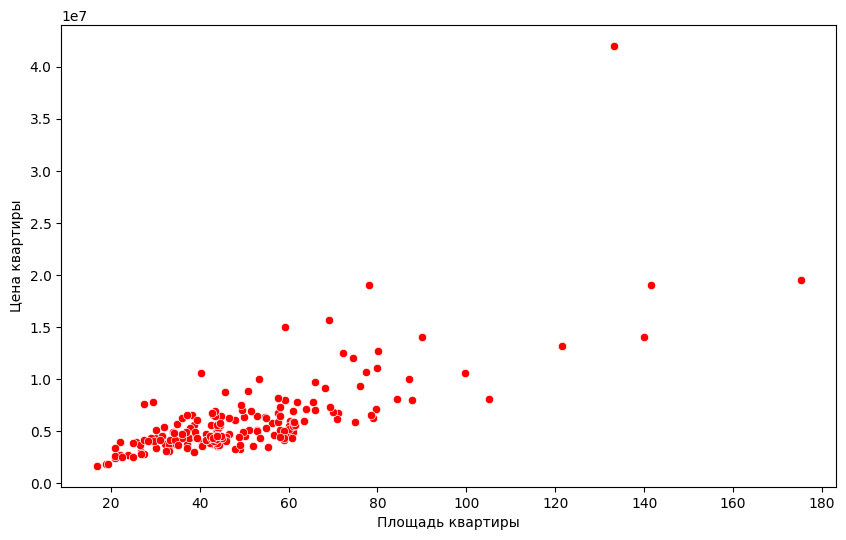

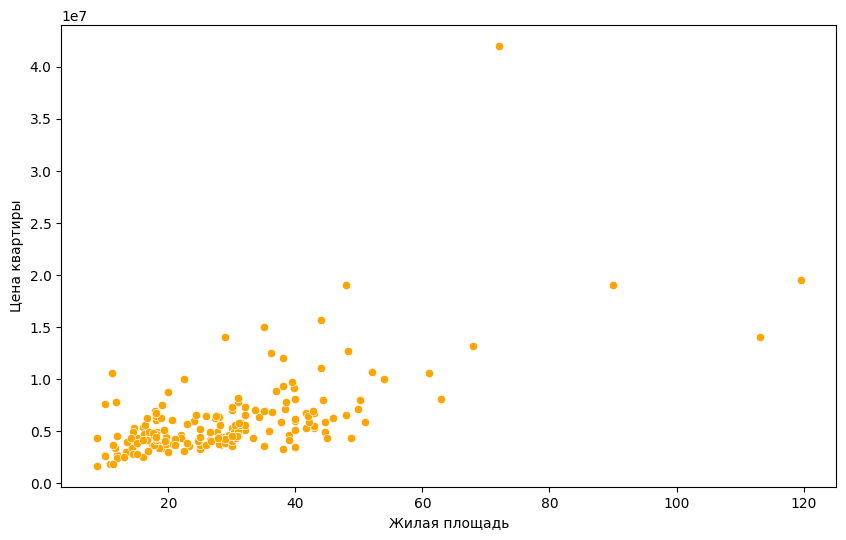

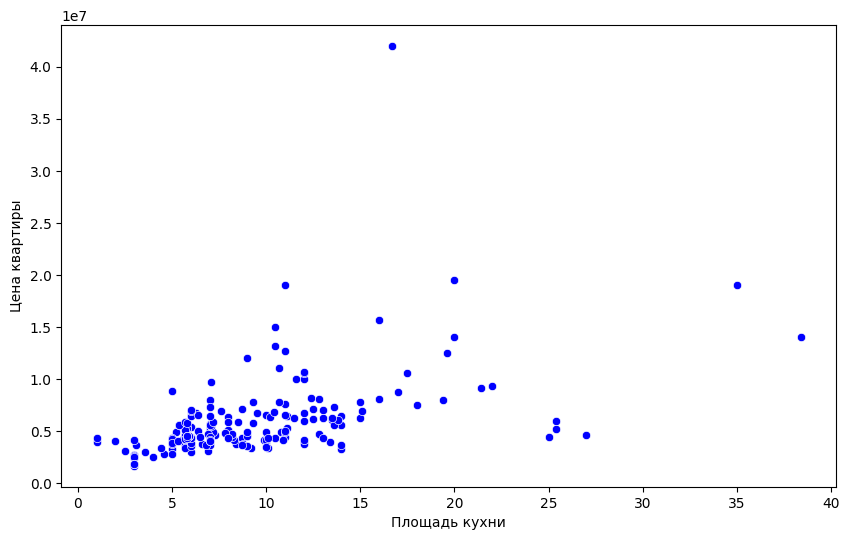

In [68]:
# EDA (old flats)

plt.figure(figsize=(10, 6))

plt.xlabel('Площадь квартиры')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_old['total_square'], y=df_old['price'], color='red')

plt.figure(figsize=(10, 6))
plt.xlabel('Жилая площадь')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_old['living_sq'], y=df_old['price'], color='orange')

plt.figure(figsize=(10, 6))
plt.xlabel('Площадь кухни')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_old['kitchen_sq'], y=df_old['price'], color='blue')


<Axes: xlabel='price', ylabel='Density'>

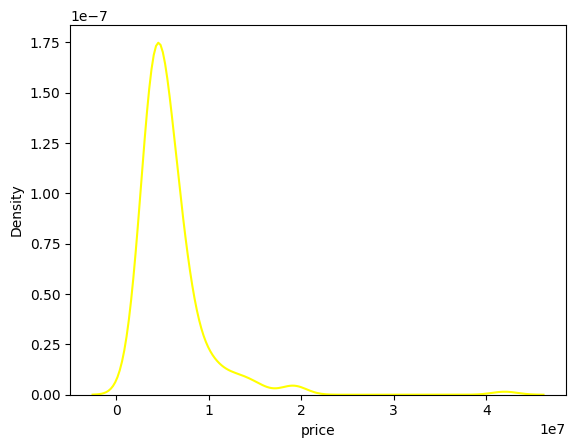

In [69]:
sns.kdeplot(df_old['price'], color='yellow')


<Axes: xlabel='total_square', ylabel='Density'>

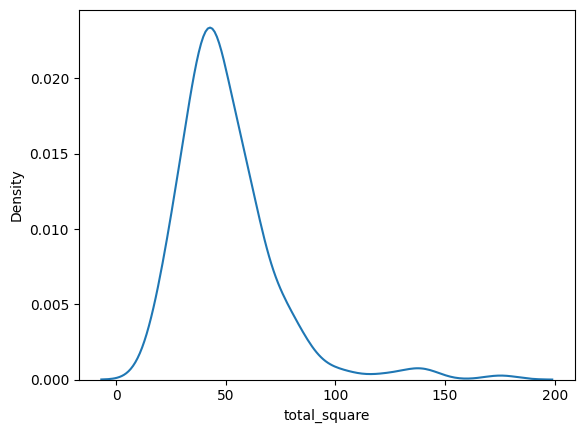

In [70]:
sns.kdeplot(df_old['total_square'])

<Axes: xlabel='Район', ylabel='Количестов квартир'>

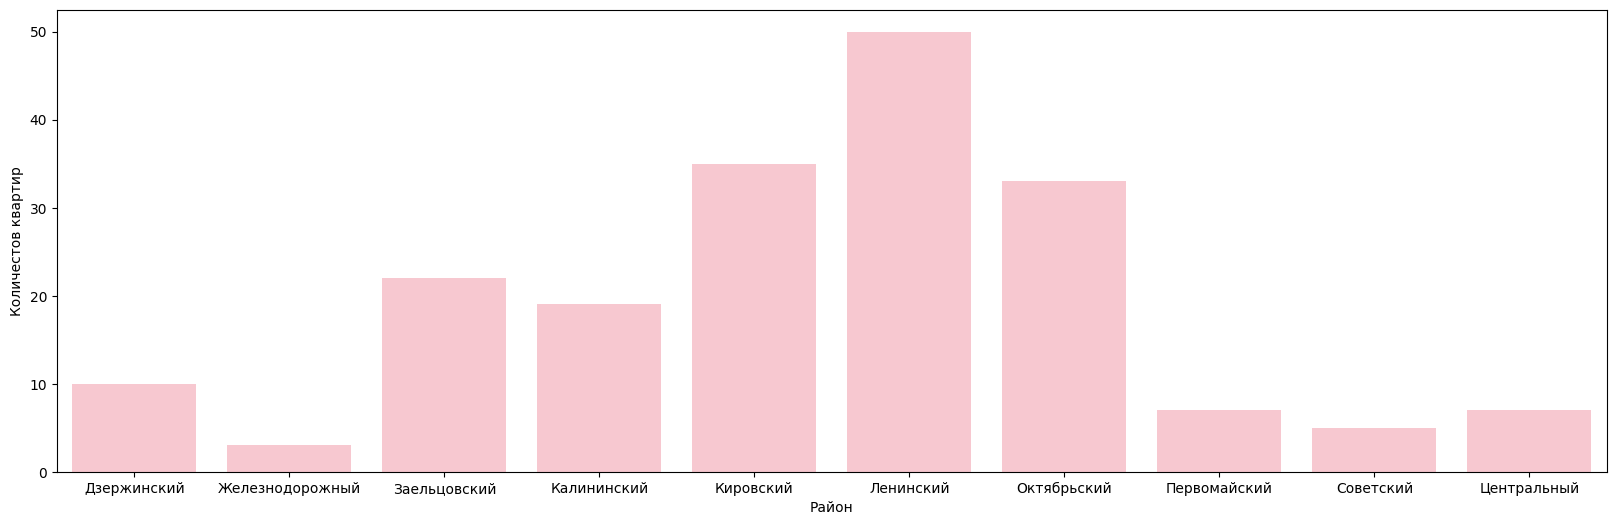

In [71]:
plt.figure(figsize=(20, 6))
plt.ylabel('Количестов квартир')
plt.xlabel('Район')
districts = df_old.groupby('district').count()['rented']
sns.barplot(districts, color='pink')

<Axes: xlabel='Вид из окна', ylabel='Цена квартиры'>

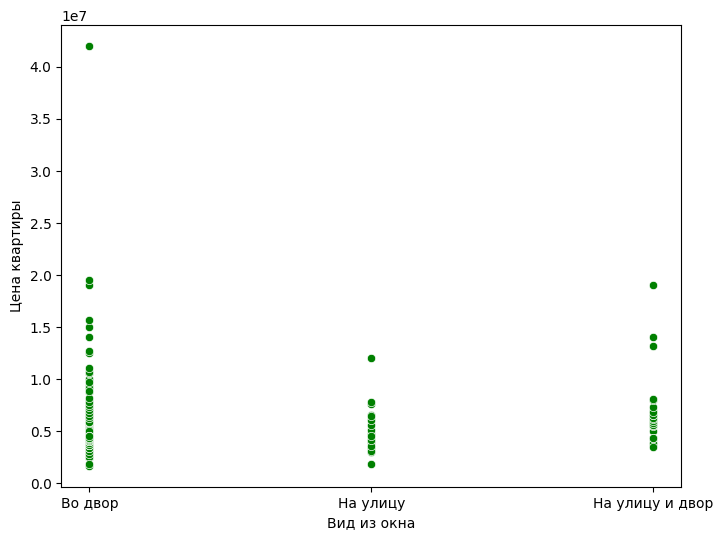

In [72]:
plt.figure(figsize=(8, 6))

plt.xlabel('Вид из окна')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_old['window_view'], y=df_old['price'], color='green')

<Axes: xlabel='Высота потолков', ylabel='Цена квартиры'>

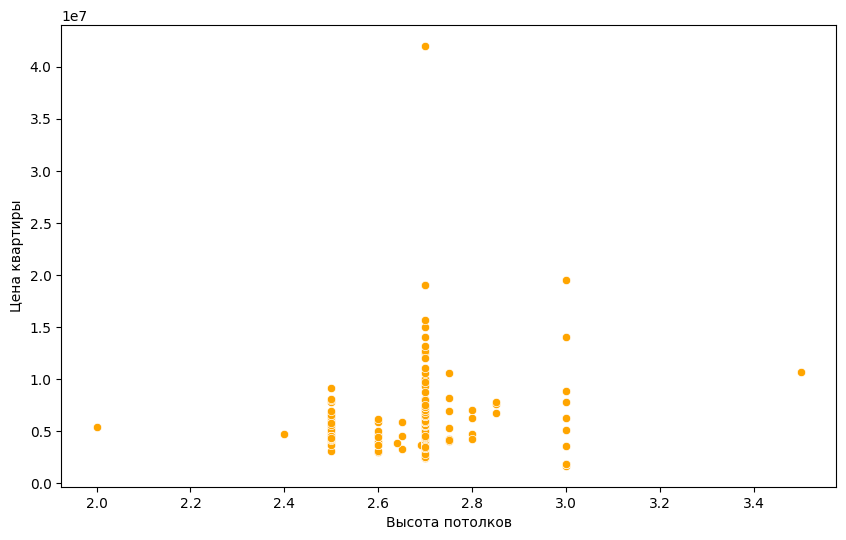

In [73]:
plt.figure(figsize=(10, 6))

plt.xlabel('Высота потолков')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_old['ceil_height'], y=df_old['price'], color='orange')

In [74]:
# outliers (old flats)

for column in['price']:
    q1 = df_old[column].quantile(0.25)
    q3 = df_old[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    df_old_dummy = df_old_dummy[df_old_dummy[column].between(lower_bound, upper_bound)]
    

<Axes: xlabel='total_square', ylabel='Density'>

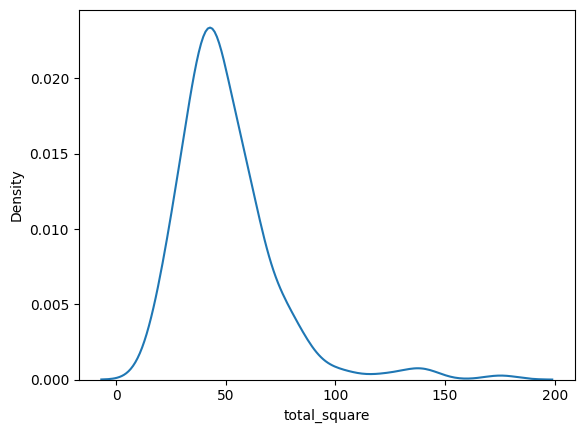

In [75]:
sns.kdeplot(df_old['total_square'])

<Axes: xlabel='Площадь кухни', ylabel='Цена квартиры'>

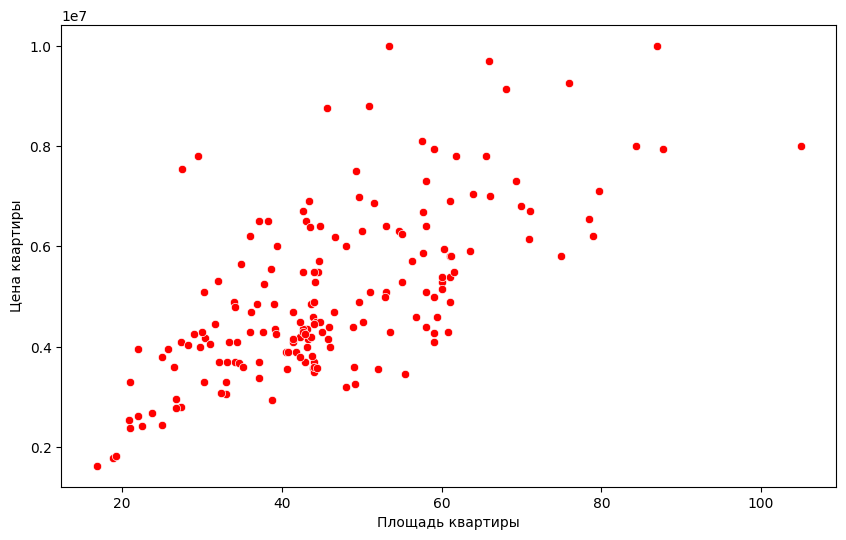

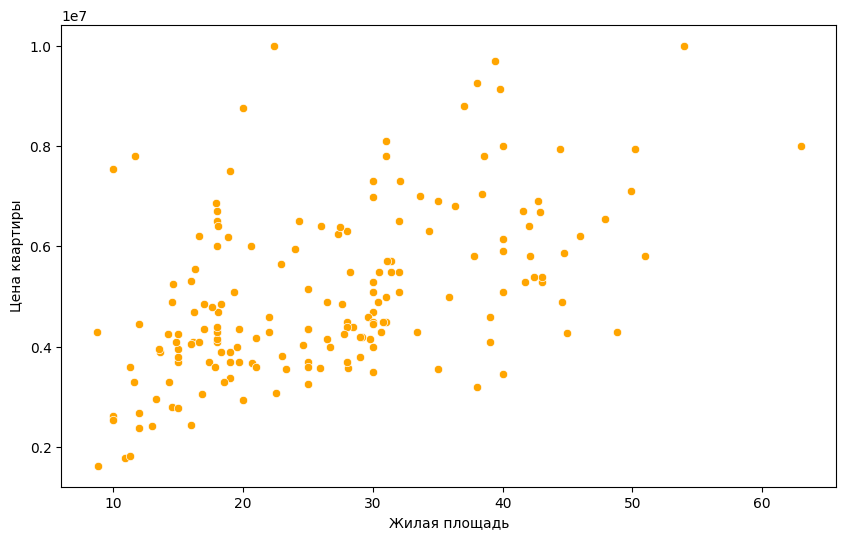

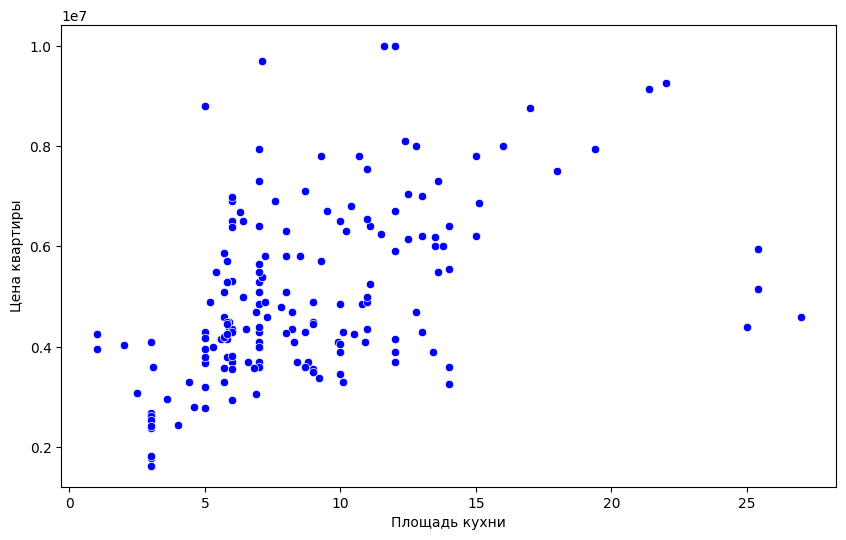

In [76]:
plt.figure(figsize=(10, 6))

plt.xlabel('Площадь квартиры')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_old_dummy['total_square'], y=df_old_dummy['price'], color='red')

plt.figure(figsize=(10, 6))
plt.xlabel('Жилая площадь')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_old_dummy['living_sq'], y=df_old_dummy['price'], color='orange')

plt.figure(figsize=(10, 6))
plt.xlabel('Площадь кухни')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_old_dummy['kitchen_sq'], y=df_old_dummy['price'], color='blue')

In [55]:
model = CatBoostRegressor()
train, test = train_test_split(df_old_dummy, test_size=0.2)
x = train.drop('price', axis=1)
y = train['price']
model.fit(x, y)

Learning rate set to 0.03001
0:	learn: 1594465.9384455	total: 142ms	remaining: 2m 22s
1:	learn: 1577233.5106735	total: 143ms	remaining: 1m 11s
2:	learn: 1561309.4710695	total: 146ms	remaining: 48.5s
3:	learn: 1547277.9839037	total: 147ms	remaining: 36.6s
4:	learn: 1528985.5990281	total: 148ms	remaining: 29.5s
5:	learn: 1511119.5567274	total: 150ms	remaining: 24.8s
6:	learn: 1493598.6085928	total: 151ms	remaining: 21.4s
7:	learn: 1477660.9317468	total: 152ms	remaining: 18.9s
8:	learn: 1462505.7955522	total: 154ms	remaining: 16.9s
9:	learn: 1447290.8805919	total: 155ms	remaining: 15.4s
10:	learn: 1432707.1554121	total: 157ms	remaining: 14.1s
11:	learn: 1419832.2580185	total: 158ms	remaining: 13s
12:	learn: 1407027.9200771	total: 160ms	remaining: 12.1s
13:	learn: 1394390.7699063	total: 161ms	remaining: 11.3s
14:	learn: 1382740.9543854	total: 162ms	remaining: 10.7s
15:	learn: 1369653.9372259	total: 164ms	remaining: 10.1s
16:	learn: 1357844.7036952	total: 165ms	remaining: 9.54s
17:	learn: 1

In [56]:
pred = model.predict(test.drop('price', axis=1))

In [59]:
mean_absolute_error(test['price'], pred)

978849.208883813